## Train a model

The objective of this notebook is train and evaluate a given model specified in the parameters file.

In [ ]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
import time
from datetime import datetime
import logging
import socket

# Set terminal output (to send mesages to the terminal stdout)
terminal_output = open('/dev/stdout', 'w')
print('Execution of Notebook started at {}'.format(datetime.now()), file=terminal_output)

In [3]:
# Load external libraries
key = 'external_libs_path'
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path, file=terminal_output)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)
# Load external libraries
#from Utils import lr_schedule_Callback
#from Utils import save_best_model_Callback
import Utils as utils
from Utils import evaluate_model
import Data_augmentation
from Models_V2 import Individual_Model_Training
# load function to print in the here and in the log file at the same time
from Utils import print_stdout_and_log as printc
from Utils import set_GPU_config as set_GPU_config
import tfds_utils

from Costum_Callbacks import set_tensorboard as set_tensorboard_CB
from Costum_Callbacks import save_best_model_base_on_CMA_Callback as CMA_CB
#from Costum_Callbacks import save_best_model_weights_in_memory_Callback as save_w_and_b
from Costum_Callbacks import print_progress_to_log as train_progress_to_log_CB

Load model parameters:

In [4]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/Quick_test_local.json'
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'

# Open parameters
if os.path.exists(PARAMETERS_FILE):
    with open(PARAMETERS_FILE) as file:
        p = json.load(file)
else:
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))

# IMPORTANT
# All outputs are saved using the model name and the name of the parameters file
# For instance, if model='ResNet50V2' and param file='test_1.json', then
# the model will be saved saved at p['model_path']/ResNet50V2/test_1

# Save parameter file path
p['parameters_file_path'] = PARAMETERS_FILE
p['external_libs_path'] = external_libs_path
# check and set default parameters
p, info = utils.set_model_default_parameters(p)
print(info)
print(p.keys())


Input parameters:

  Model parameters:
    Selected model: Quick_test
    Pretraining: 0
    Dense layers regularization (l1, l2): [0, 0]
    Conv layers regularization (l1, l2): [0, 0]
    Bias L2 reg (for dense and conv layers): 0
    Number of epochs: 65
    Loss function: huber
    Learning rate: 0.001
    Batch size: 32
    Verbose level: 1

  Output:
    Base name for files: Quick_test_local
    Model output: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local
    Clean base_path? 1

  Dataset:
     TFDS name: mpp_ds_normal_dmso_ls_me
    Selected input channels: 
    ['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRN

Set logging:

In [5]:
# Set logging configuration
logging.basicConfig(
    filename=p['log_file'],
    filemode='w', 
    level=getattr(logging, 'INFO')
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))
msg = 'Log file: '+p['log_file']
# print selected parameters into the log
logging.info(info)
# Print location of the log file into the terminal
print(msg, file=terminal_output)

In [6]:
# Set GPU config
set_GPU_config(p['disable_gpu'], p['set_memory_growth'])

Cuda devices (GPUs) disabled
Physical GPU devises:
[]
It was not possible to limit GPU memory


Create dirs where model output will be saved:

In [7]:
# If you want to avoid cleaning (deleting) model dir, then uncomment the next line:
#p['clean_model_dir'] = 0

base_path, model_path, checkpoints_path = utils.create_model_dirs(parameters=p)

msg = 'Base path:\n{}'.format(base_path)
msg += '\nModel path:\n{}'.format(model_path)
msg += '\nCheckpoints path:\n{}'.format(checkpoints_path)
printc(msg)

Warning! Directory /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local already exist! Deleting...

Creating dir: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local
Base path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local
Model path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/model
Checkpoints path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/checkpoints


# 1.- Dataset

## 1.1.- Load the dataset

In [8]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=p['shuffle_files'],
    with_info=True)

# Load splits
train_data, val_data = dataset['train'], dataset['validation']

msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
printc(msg)

Tensorflow dataset mpp_ds_normal_dmso_ls_me loaded from:
/data/Master_Thesis_data/datasets/tensorflow_datasets


In [9]:
print(ds_info.description)

Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate. The cell mask is saved on the last channel of the cell image.
This Dataset was builded after a preprocessing using the python script MPPData_into_images_no_split.ipynb. During this preprocessing the original MPPData was:
- Converted into image, mask and target vector.
- Cleaned. Border and mitotic cells were removed.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbations 'TSA' seams not to have influence over the TR (00_EU avg), it seams to have an influence on the intensity of the channel H3K27ac, and therefore it is not included. Only normal, DMSO (perturbations).


To load more info about this TDFS (cell metadata df, channels df containing preprocessing parameters, the used TFDS and preprocessing arameters) after loading this TFDS run:

In [10]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=57>,
 'train': <tfds.core.SplitInfo num_examples=449>,
 'validation': <tfds.core.SplitInfo num_examples=56>}

In [11]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [12]:
# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

dict_keys(['data_pp_parameters', 'channels_df', 'tfds_creation_parameters', 'metadata_df'])

In [13]:
tfds_metadata['channels_df']

,original_channel_id,name,train_98_percentile,train_mean_after_clipping_and_LS,type,TFDS_channel_id
0,0.0,00_DAPI,70.300003,0.519192,input,0.0
1,1.0,07_H2B,313.299988,0.570965,input,1.0
2,2.0,01_CDK9_pT186,53.889076,0.283255,input,2.0
3,3.0,03_CDK9,94.797798,0.304709,input,3.0
4,4.0,05_GTF2B,192.166107,0.475074,input,4.0
5,5.0,07_SETD1A,96.989853,0.252042,input,5.0
6,6.0,08_H3K4me3,109.921074,0.374878,input,6.0
7,7.0,09_SRRM2,271.374664,0.161589,input,7.0
8,8.0,10_H3K27ac,185.104874,0.393830,input,8.0
9,9.0,11_KPNA2_MAX,121.093430,0.439018,input,9.0


In [14]:
tfds_metadata['metadata_df']

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set
0,373506,373535,plate01,I09,0,0,0,0,6,0,plate01,I09,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12969.0,43.893030,175.995428,27.577226,54.206169,128.697294,41.469521,60.416069,64.842372,125.169772,65.557846,105.751293,192.479292,78.460671,49.046642,187.326717,99.378451,117.227410,26.282266,60.407161,33.006360,131.946547,28.173045,54.011811,187.774103,131.526724,385.672558,11.862217,81.837107,291.005551,51.128612,368.260323,285.676524,11.584543,8.256946,1.803026,599.449225,8305.377207,10121.675842,0.687500,train
1,373507,373536,plate01,I09,0,0,0,0,7,0,plate01,I09,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,9846.0,39.837376,273.655677,12.569294,22.001503,81.730022,20.032913,39.631146,44.481310,73.860256,54.789958,67.896671,162.914590,35.864765,37.245010,355.807515,67.943580,76.462250,12.614654,55.775873,14.612852,120.283067,19.574581,41.063924,101.116543,55.055405,297.648758,11.671538,91.374197,329.135675,33.598199,335.386680,410.320858,9.813957,5.888977,1.561608,398.334857,6055.847451,10278.970546,0.598214,val
2,373508,373537,plate01,I09,0,0,0,0,8,0,plate01,I09,0,0,0,0,8,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,7714.0,44.735922,258.942987,23.616477,47.406444,140.684383,44.831516,68.078372,67.289663,85.795525,90.090190,87.339633,249.505730,88.193348,51.833120,332.372822,124.072929,130.945283,38.285344,76.223063,43.566143,151.189717,39.663339,71.273700,205.703836,124.654347,332.255405,17.381051,196.612601,361.317387,55.593623,457.713302,469.516855,14.441616,9.757942,1.859657,464.431683,8280.577392,11757.616541,0.500000,test
3,373509,373538,plate01,I09,0,0,0,0,9,0,plate01,I09,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,15718.0,43.931378,194.444293,18.353704,32.399117,104.564078,29.361877,46.617407,51.506499,127.183208,55.535536,94.269486,171.038290,77.086018,32.756867,212.862917,74.396402,81.701189,15.256486,49.931726,19.315464,136.797350,21.712636,45.183902,148.422635,82.323469,284.648928,8.077076,50.190543,271.552491,37.614959,285.612350,263.922204,7.988940,6.477020,1.717521,425.533338,7441.930589,8530.446240,0.678571,val
4,373510,373539,plate01,I09,0,0,0,0,10,0,plate01,I09,0,0,0,0,10,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12229.0,30.892690,231.842236,19.046228,37.117579,100.918987,25.272207,43.387094,43.176593,78.249253,76.013457,112.938592,178.444723,81.792631,41.639270,292.071767,90.931247,99.625565,27.330404,66.549839,20.411372,107.398853,23.828493,55.354041,134.139140,99.027838,301.044591,15.211128,122.575573,334.431894,42.139486,362.906348,438.364101,10.736532,6.967087,1.697280,410.540764,5541.760160,10350.776433,0.633929,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,248051,248096,plate01,I09,5,4,0,0,31,0,plate01,I09,5,4,0,0,31,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,11135.0,34.088505,155.096587,13.024716,28.9366

## 1.2.- Data preprocessing, data augmentation techniques

Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

### Specify input channels

In [15]:
# Load Channels file
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)

# Get selected channel ids
input_ids = np.array(tfds_metadata['channels_df'].set_index(['name']).loc[selected_channels].TFDS_channel_id.values)
input_ids = input_ids.astype(np.int16)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
printc(msg)
printc('\nNumber of input channels to use in the model:\n{}'.format(input_ids.shape[0]))

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]

Number of input channels to use in the model:
33


### Apply preprocessing and data augemntation


random_normal selected as CenterZoom_mode. Distribution parameters:
mean: 0.6438911867642381, stddev: 0.09555848908420726, lower bound: 0.4375


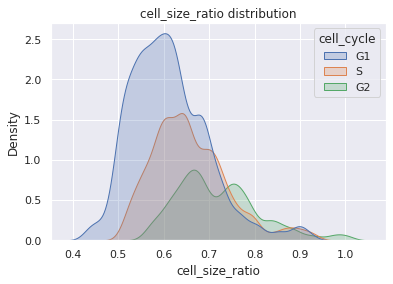

In [16]:
# if cell size is sampled from a normal distribution, calculate the parameters 
# of the distribution using the train set
if (p['CenterZoom_mode'] == 'random_normal') and p['CenterZoom']:
    
    mask = (tfds_metadata['metadata_df'].set == 'train')
    p['cell_size_ratio_mean'] = tfds_metadata['metadata_df'][mask].cell_size_ratio.mean()
    p['cell_size_ratio_stddev'] = tfds_metadata['metadata_df'][mask].cell_size_ratio.std()
    p['cell_size_ratio_low_bound'] = tfds_metadata['metadata_df'][mask].cell_size_ratio.min()
    msg = '\nrandom_normal selected as CenterZoom_mode. Distribution parameters:'
    msg += '\nmean: {}, stddev: {}, lower bound: {}'.format(p['cell_size_ratio_mean'], p['cell_size_ratio_stddev'], p['cell_size_ratio_low_bound'])
    printc(msg)
    
    hue_order = ['G1', 'S', 'G2']
    sns.kdeplot(data=tfds_metadata['metadata_df'][mask],
            x='cell_size_ratio',
            hue='cell_cycle',
            hue_order=hue_order,
            shade=True,
            bw_method=0.2
           )
    plt.title('cell_size_ratio distribution')

Take a look into one image and the selected data augmentation techniques:

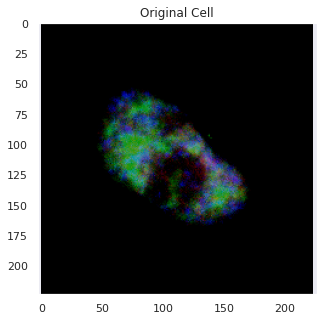

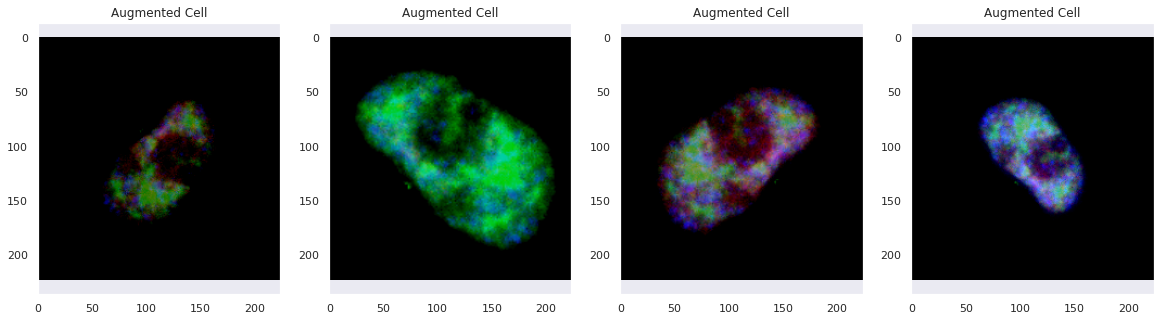

In [17]:
# Get one batch to print a cell
images, targets = next(iter(val_data))

# add an extra dim (like a batch)
image = tf.expand_dims(images, axis=0)
Data_augmentation.visualize_data_augmentation(image, p)

In [18]:
# Get some necessary stuff for data preprocessing (projection tensor to filter the input channels)
input_shape = np.array(ds_info.features['image'].shape)
projection_tensor = Data_augmentation.get_projection_tensor(input_shape, input_ids)

# Prepare train and validation datasets
train_data, val_data = Data_augmentation.prepare_train_and_val_TFDS(train_data,
                                                                    val_data,
                                                                    projection_tensor,
                                                                    p)

# 3.- Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [19]:
img_shape = ds_info.features['image'].shape[:-1] + (input_ids.shape[0],)

# init model class
temp_run = Individual_Model_Training()

# init model architectur
temp_run.init_model(arch_name=p['model_name'],
                    input_shape=img_shape,
                    conv_reg=p['conv_reg'],
                    dense_reg=p['dense_reg'],
                    bias_l2_reg=p['bias_l2_reg'],
                    pre_training=p['pre_training'])

# select loss function and build the model
temp_run.build_model(loss_name=p['loss'], learning_rate=p['learning_rate'])

Individual_Model_Training class initialed
Model Quick_test selected!
Regularization:
conv_l1_reg: 0, conv_l2_reg: 0
dense_l1_reg: 0, dense_l2_reg: 0
Bias l2 reg: 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)           

### Set model callbacks

In [20]:
# Set tensorboard callbacks
if p['tensorboard']:
    tensorboard = set_tensorboard_CB(log_path=p['log_path'], log_dir_name=p['model_name'])
    temp_run.callbacks.append(tensorboard)

# set Center moving average callback
avg_sizes = [11, 21, 31]
monitor='val_mean_absolute_error'
loss_CMA = CMA_CB(monitor, avg_sizes)
temp_run.callbacks.append(loss_CMA)

# Set callback to print train progren in log file
train_progress_to_log = train_progress_to_log_CB(p['number_of_epochs'])
temp_run.callbacks.append(train_progress_to_log)

# print loaded callbacks
msg = 'Loaded callbacks:\n{}'.format(temp_run.callbacks)
printc(msg)

Loaded callbacks:
[<Costum_Callbacks.save_best_model_base_on_CMA_Callback object at 0x7ff8f03c3c40>, <Costum_Callbacks.print_progress_to_log object at 0x7ff8f03c3bb0>]


### Fit the model

In [21]:
temp_run.fit_model(train_data, val_data, p['number_of_epochs'], p['verbose_level'])

Starting model training...
Epoch 1/65
15/15 [==============================] - ETA: 0s - loss: 388.2884 - mse: 155074.3906 - mean_absolute_error: 388.7884
Best general model updated for epoch 1; New value = 381.38 < inf = last value
15/15 [==============================] - 25s 2s/step - loss: 388.2884 - mse: 155074.3906 - mean_absolute_error: 388.7884 - val_loss: 380.8811 - val_mse: 149457.4844 - val_mean_absolute_error: 381.3811
Epoch 2/65
15/15 [==============================] - ETA: 0s - loss: 387.9889 - mse: 154813.0938 - mean_absolute_error: 388.4889
Best general model updated for epoch 2; New value = 381.27 < 381.38 = last value
15/15 [==============================] - 26s 2s/step - loss: 387.9889 - mse: 154813.0938 - mean_absolute_error: 388.4889 - val_loss: 380.7715 - val_mse: 149372.6094 - val_mean_absolute_error: 381.2715
Epoch 3/65
15/15 [==============================] - ETA: 0s - loss: 387.6790 - mse: 154575.4844 - mean_absolute_error: 388.1790
Best general model updated f

### Plot Loss

In [22]:
history = temp_run.history.history
metrics = temp_run.metrics

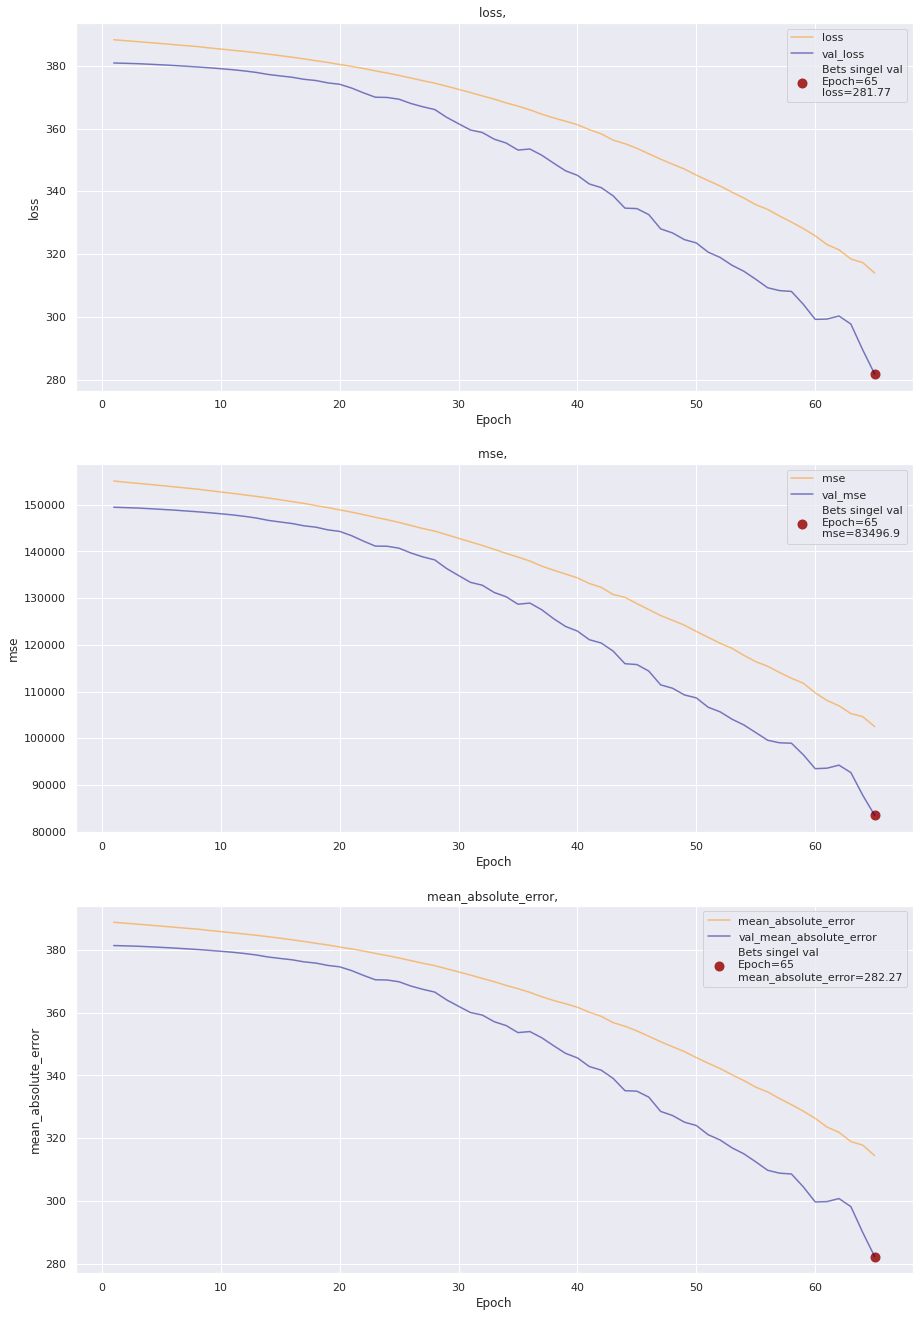

In [23]:
utils.plot_train_metrics(history=history, metrics=['loss']+metrics, p=p, figsize=(15,23))

In [24]:
msg = 'Saiving trained model'
logging.info(msg)

# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as file:
    json.dump(history, file, indent=4)
    
# Save CMA history
# First wee need to convert from np.int64 and np.float64 to regular python int and float
temp_dict = {}
for key in loss_CMA.CMA_history.keys():
    temp_dict[key] = [[int(item[0]), float(item[1])] for item in loss_CMA.CMA_history[key]]
with open(os.path.join(base_path, 'CMA_history.json'), 'w') as file:
    json.dump(temp_dict, file, indent=4)
    
# Save parameters
with open(os.path.join(base_path, 'parameters.json'), 'w') as file:
    json.dump(p, file, indent=4)

In [25]:
# Load history
#path = ''
#with open(os.path.join(path, 'history.json'), 'r') as file:
#    history = json.load(file)
# Save parameters
#with open(os.path.join(base_path, 'parameters.json'), 'r') as file:
#    p = json.load(file)
#metrics = ['mse', 'mean_absolute_error']

# Model evaluation

In [26]:
# Create data frame to save model metrics
metrics_df = pd.DataFrame()

## 1.- Last model

In [27]:
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor)
model_eval.targets_df.head()

,y,y_hat,mapobject_id_cell,set,y - y_hat,perturbation,cell_cycle
0,489.283569,115.604584,200732,train,373.678986,normal,S
1,349.570404,48.375324,366430,train,301.195080,normal,G1
2,376.229004,115.657913,290989,train,260.571091,normal,G1
3,346.474609,49.460579,359335,train,297.014030,normal,G1
4,381.863281,51.748798,256525,train,330.114483,normal,G1


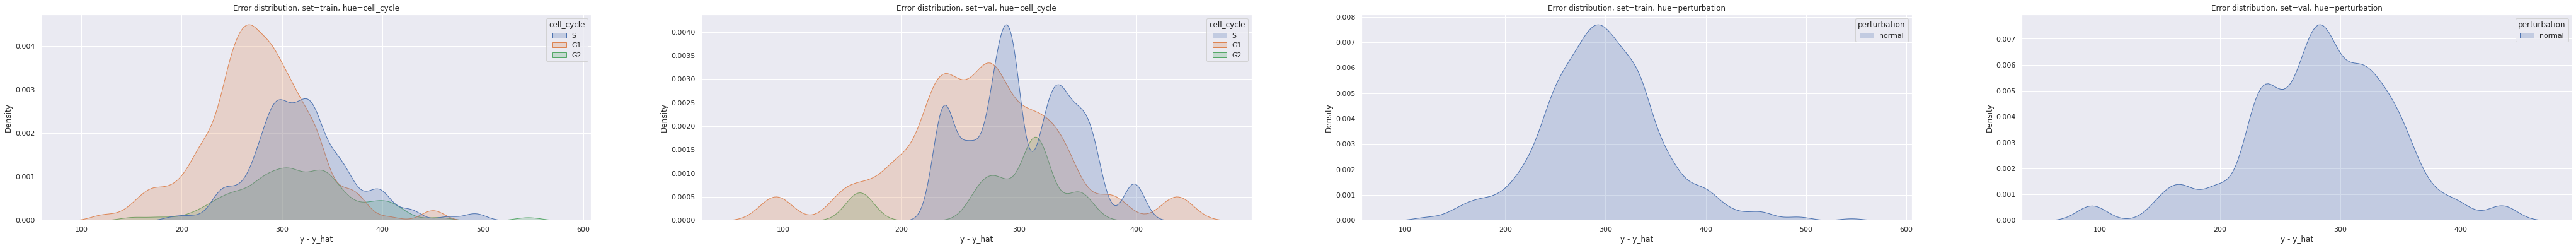

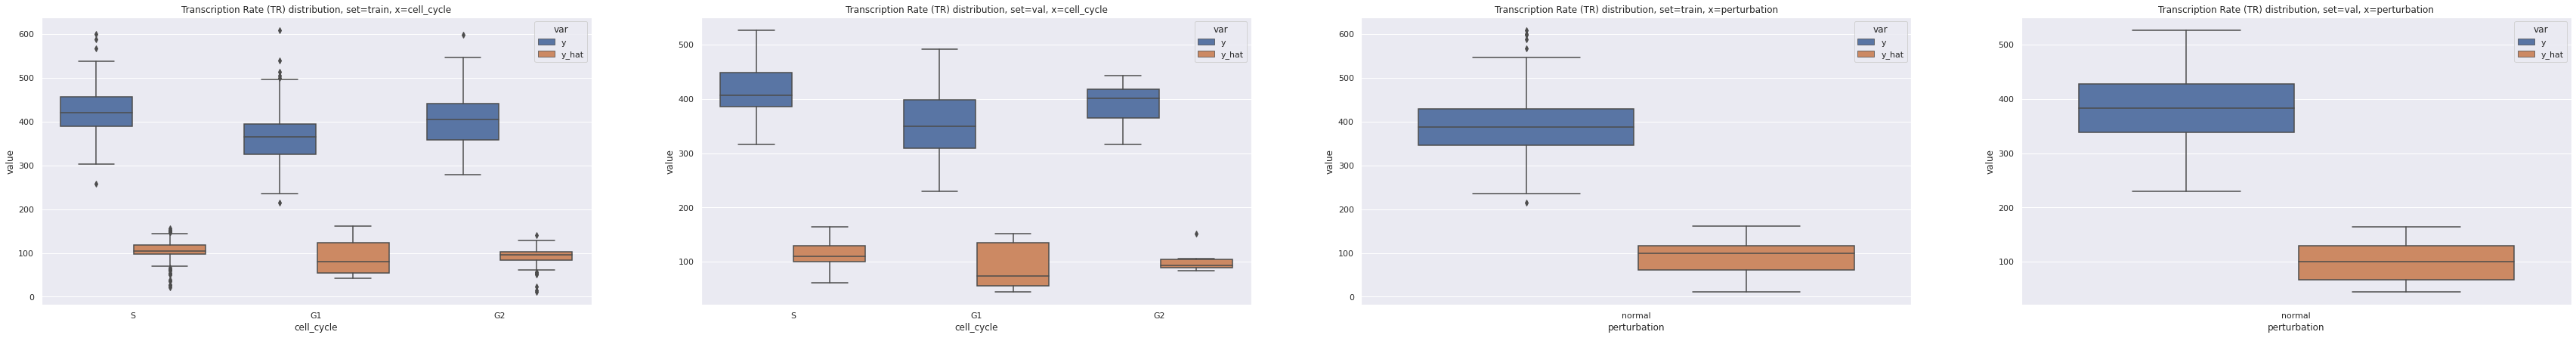

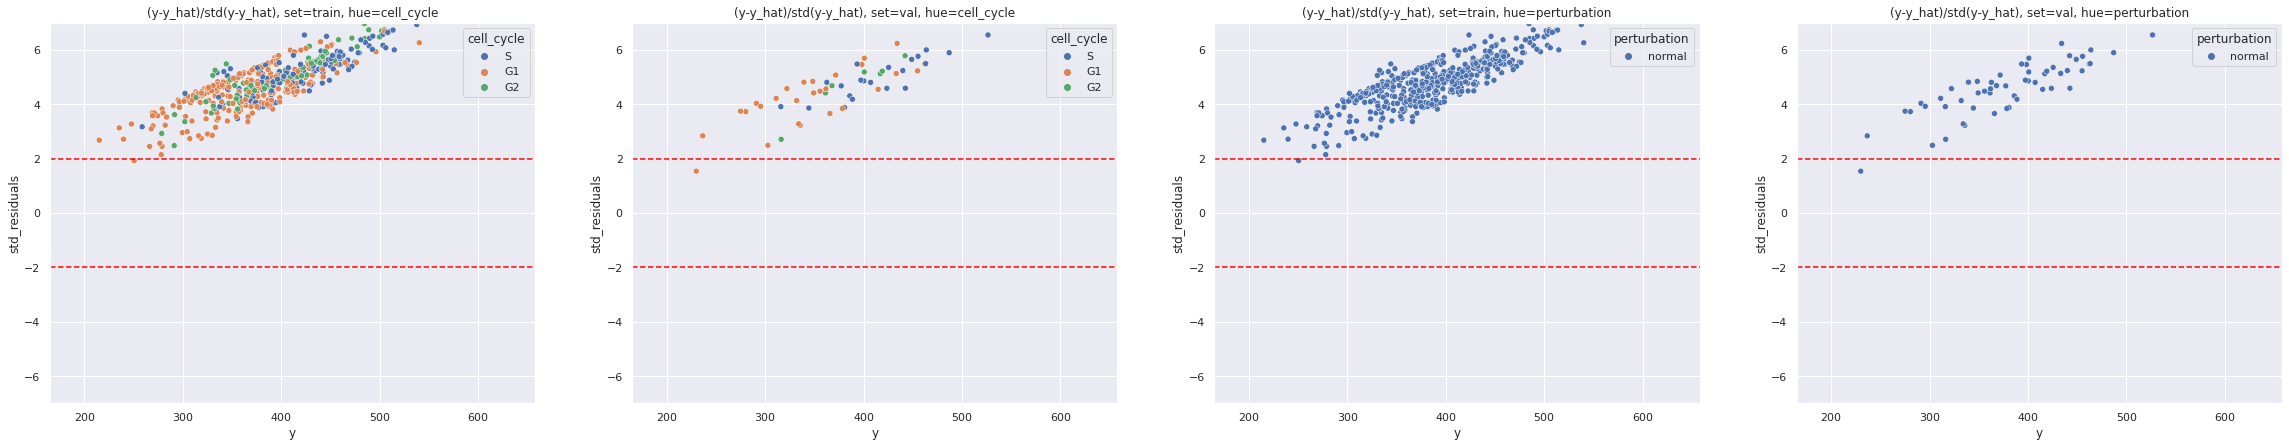

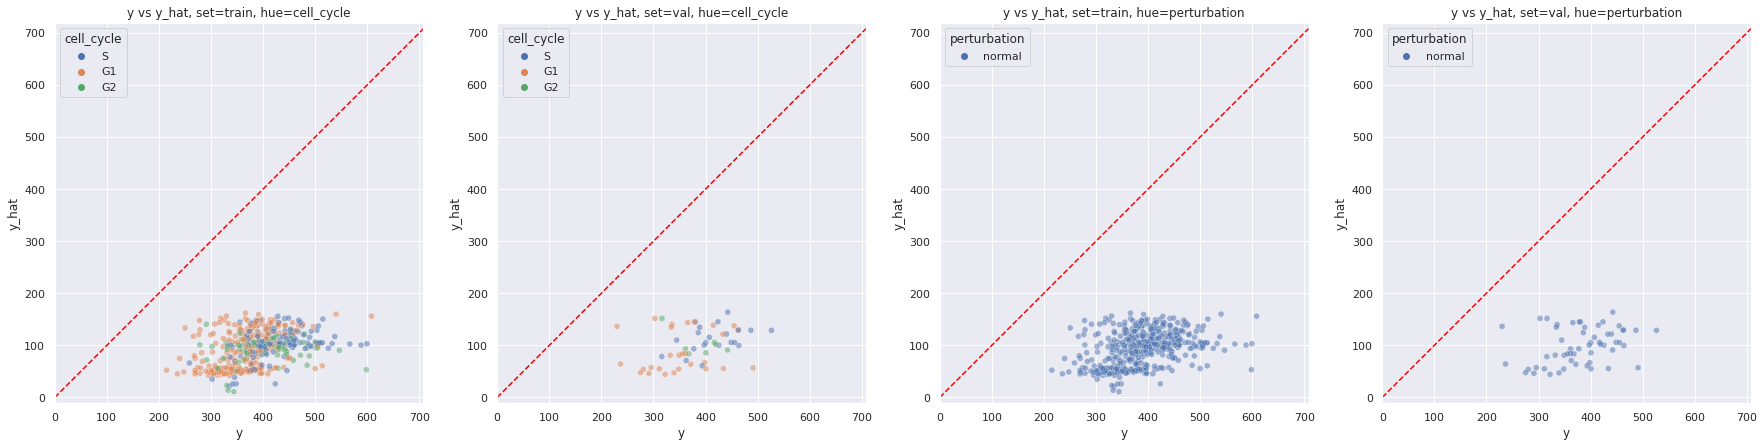

In [28]:
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [29]:
model_eval.get_metrics()
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
1,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,295.5020,58.7735,-22.0715,295.5020,90768.0740,295.0020,0,0,0,0,/home/hhughes/Documents/Master_Thesis/Project/...
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,282.2748,62.3479,-19.8335,282.2748,83496.9027,281.7748,0,0,0,0,/home/hhughes/Documents/Master_Thesis/Project/...


## 2.- Best model with no Center Moving Average (CMA_0)

In [30]:
eval_name='CMA_0'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/model/CMA_0/assets


,y,y_hat,mapobject_id_cell,set,y - y_hat,perturbation,cell_cycle
0,489.283569,115.604584,200732,train,373.678986,normal,S
1,349.570404,48.375324,366430,train,301.195080,normal,G1
2,376.229004,115.657913,290989,train,260.571091,normal,G1
3,346.474609,49.460579,359335,train,297.014030,normal,G1
4,381.863281,51.748798,256525,train,330.114483,normal,G1


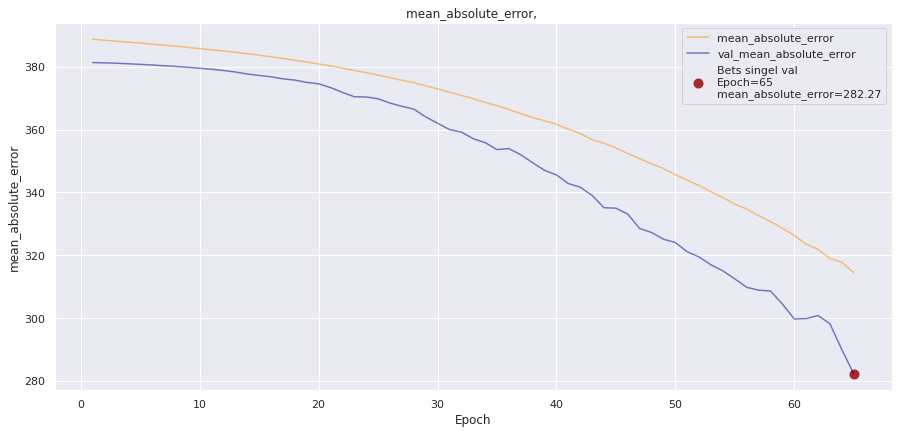

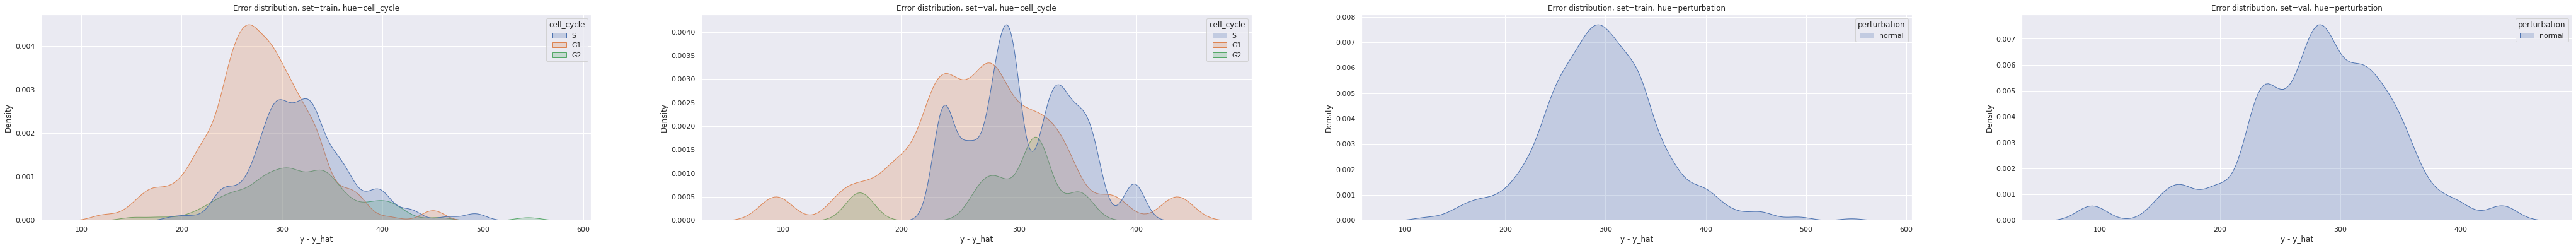

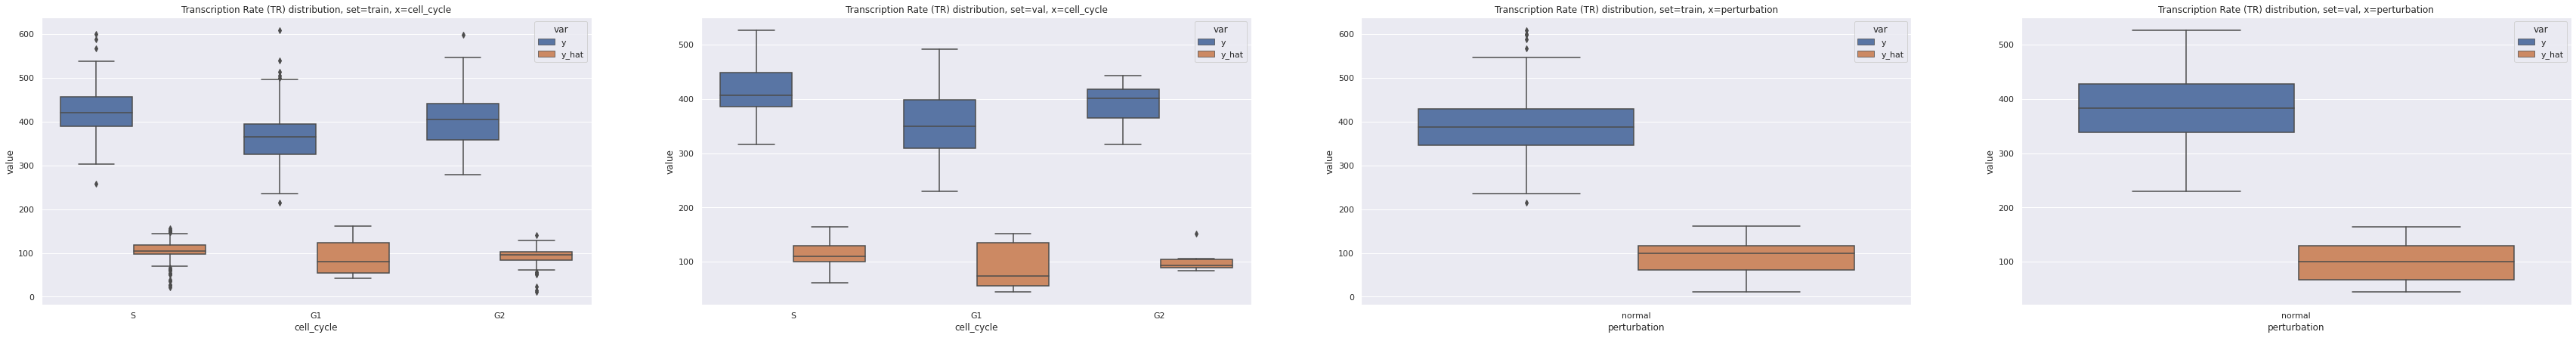

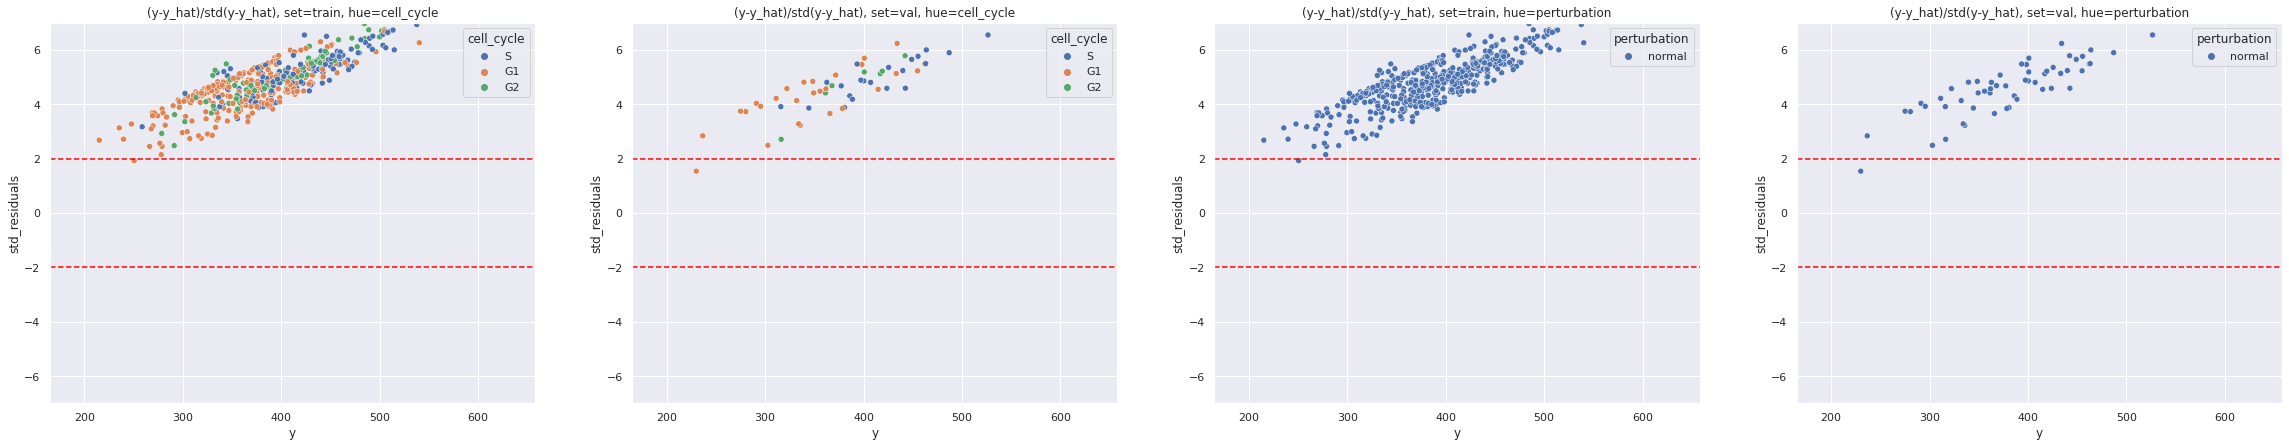

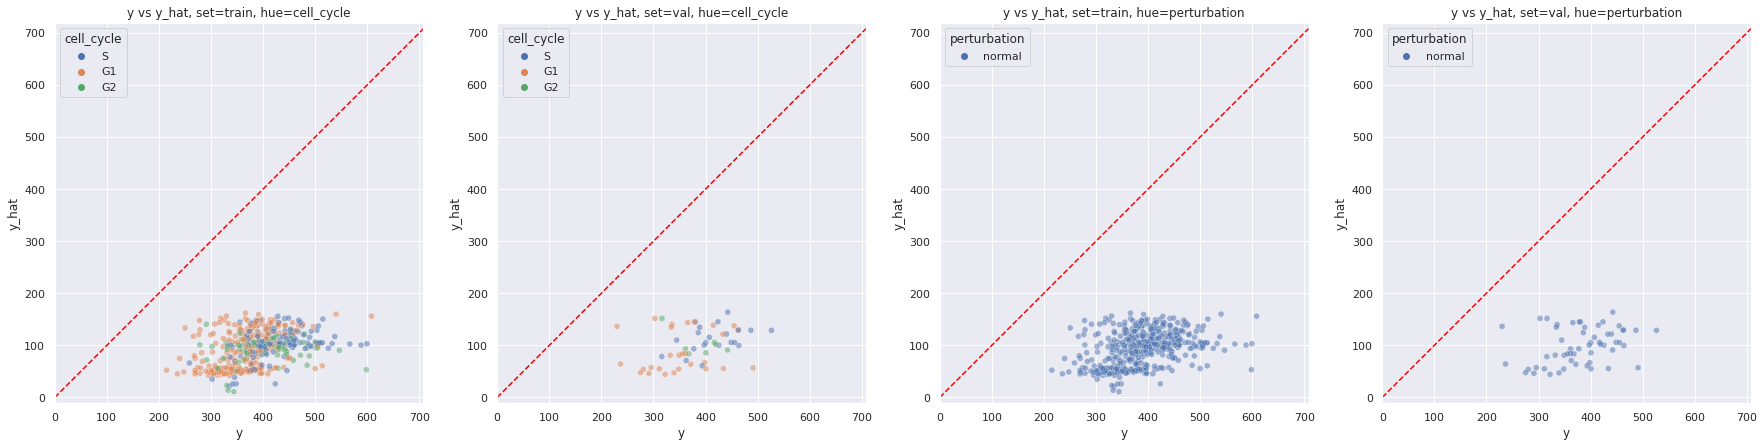

In [31]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         metrics=['mean_absolute_error'], 
                         p=p,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [32]:
model_eval.get_metrics(CMA_size=0, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
1,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,295.5020,58.7735,-22.0715,295.5020,90768.0740,295.0020,0,282.2748,0,65,/home/hhughes/Documents/Master_Thesis/Project/...
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,282.2748,62.3479,-19.8335,282.2748,83496.9027,281.7748,0,282.2748,0,65,/home/hhughes/Documents/Master_Thesis/Project/...


## 3.- Best model wrt Central Moving Average of size 11 (CMA_11)

In [33]:
eval_name='CMA_11'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/model/CMA_11/assets


,y,y_hat,mapobject_id_cell,set,y - y_hat,perturbation,cell_cycle
0,489.283569,96.022781,200732,train,393.260788,normal,S
1,349.570404,43.845203,366430,train,305.725201,normal,G1
2,376.229004,98.324509,290989,train,277.904495,normal,G1
3,346.474609,44.322216,359335,train,302.152393,normal,G1
4,381.863281,45.237068,256525,train,336.626213,normal,G1


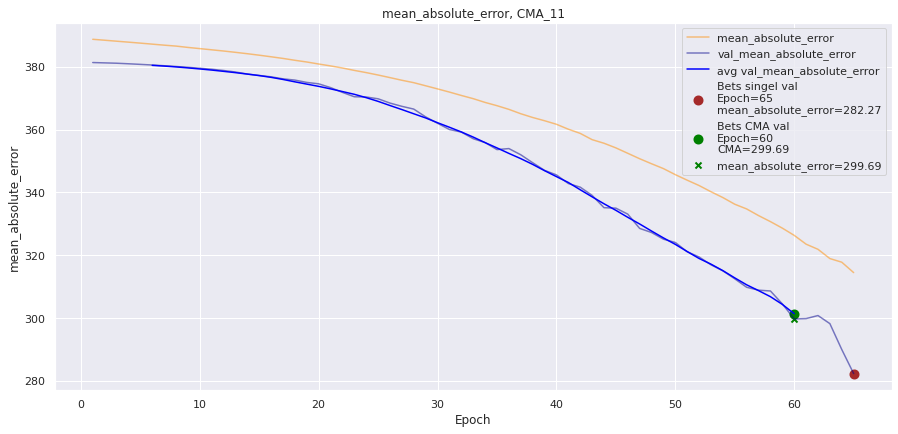

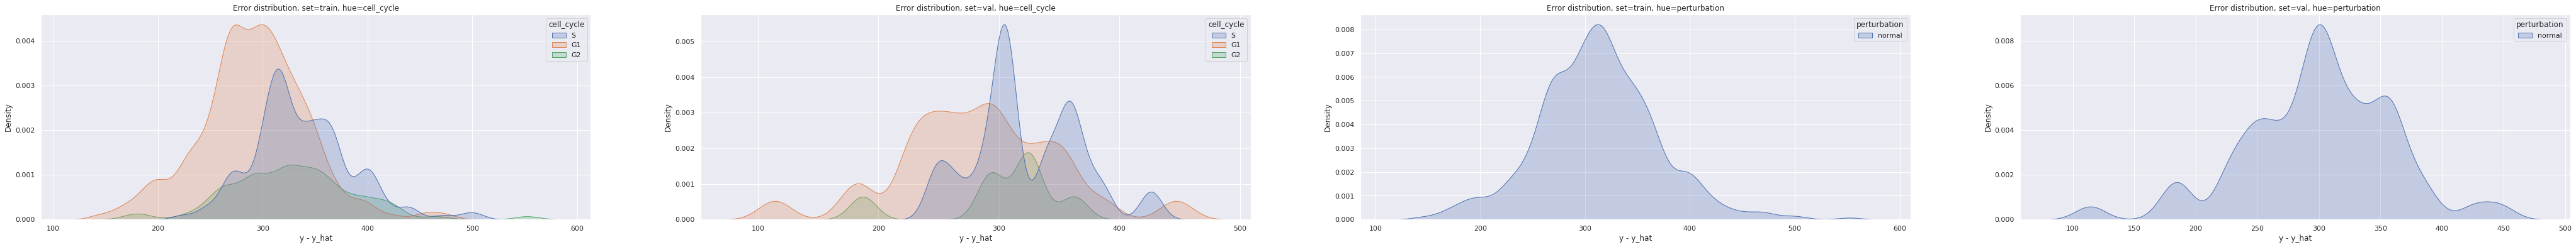

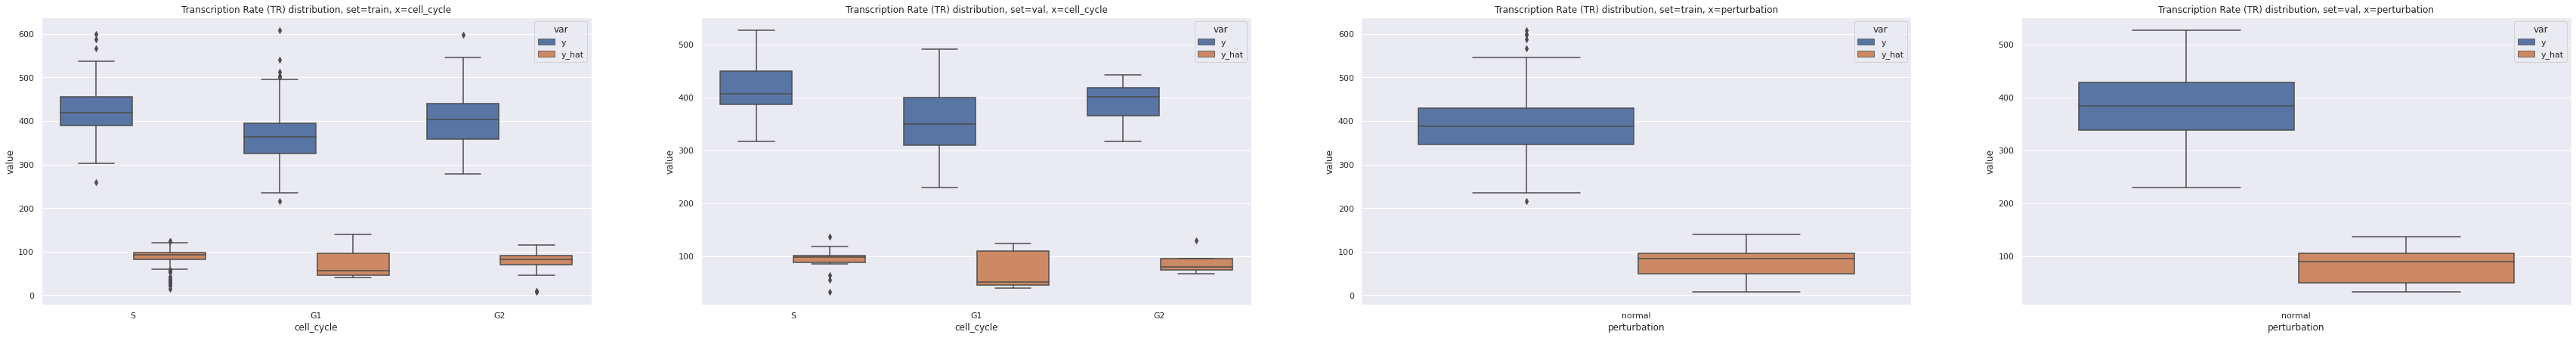

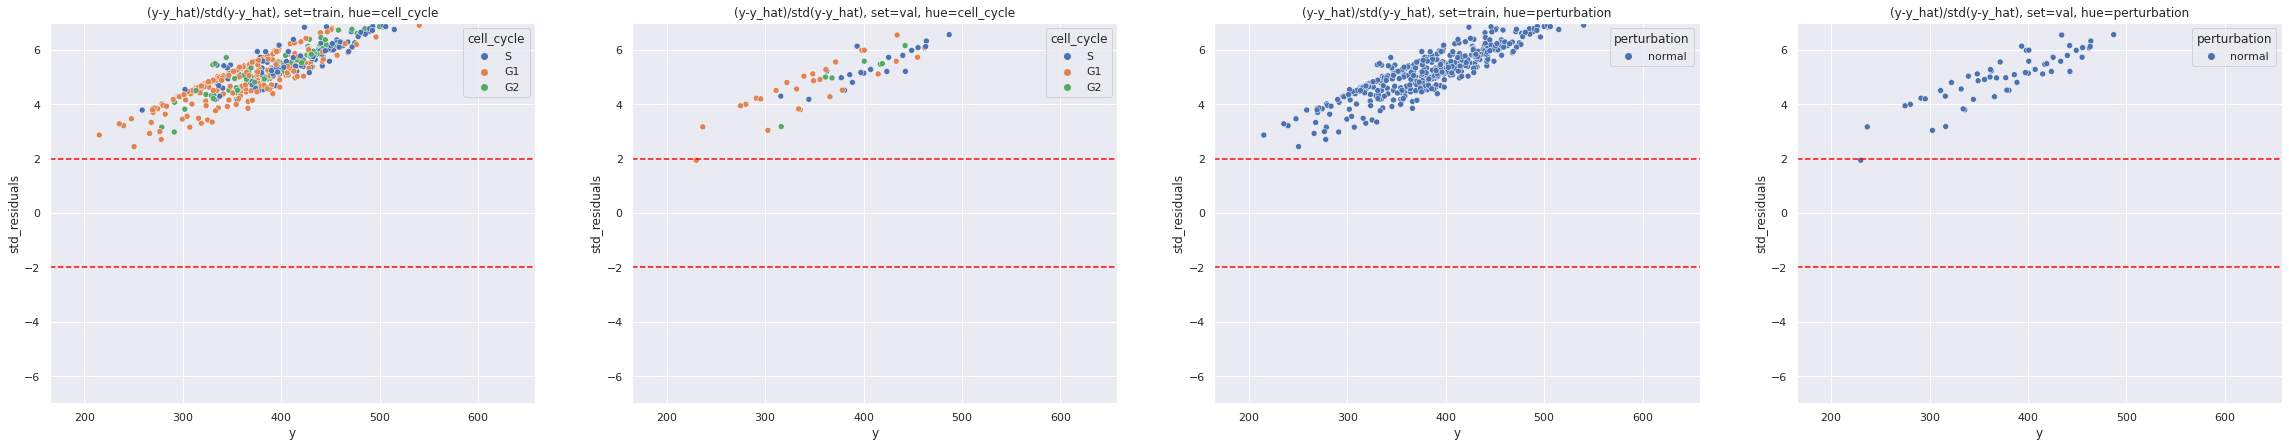

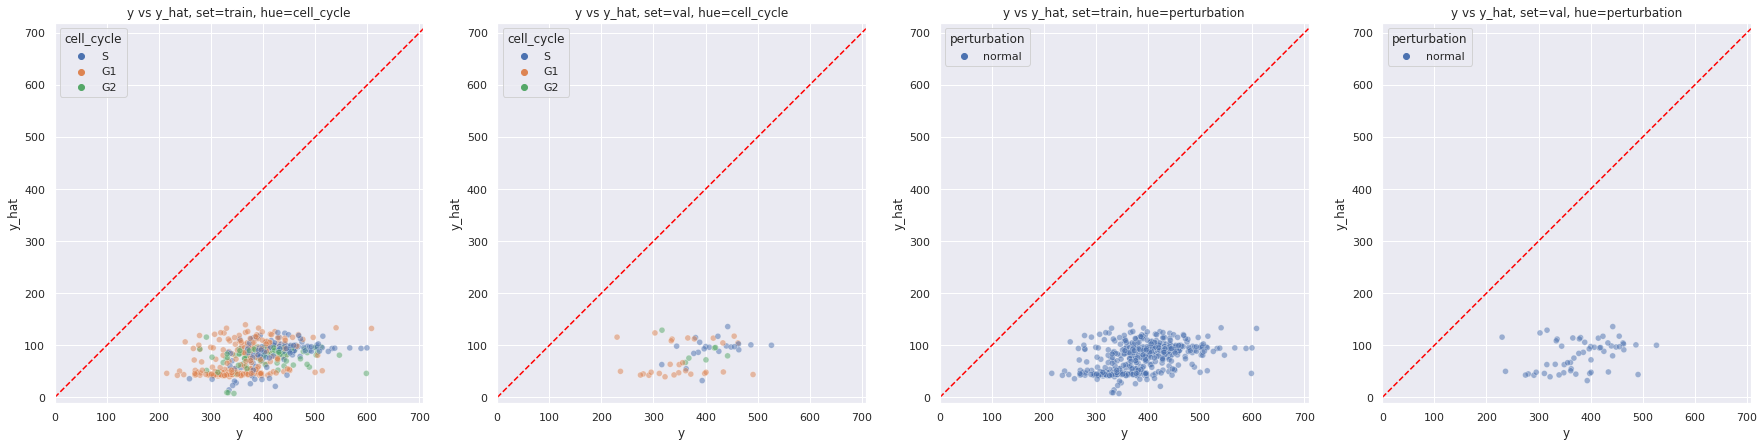

In [34]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         CMA_history=loss_CMA.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [35]:
model_eval.get_metrics(CMA_size=11, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
1,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,312.1372,57.0099,-24.5890,312.1372,100672.4904,311.6371,11,301.349,8.6477,60,/home/hhughes/Documents/Master_Thesis/Project/...
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,299.6909,61.1037,-22.3248,299.6909,93481.6050,299.1909,11,301.349,8.6477,60,/home/hhughes/Documents/Master_Thesis/Project/...


## 4.- Best model wrt Central Moving Average of size 21 (CMA_21)

In [36]:
eval_name='CMA_21'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/model/CMA_21/assets


,y,y_hat,mapobject_id_cell,set,y - y_hat,perturbation,cell_cycle
0,489.283569,83.233925,200732,train,406.049644,normal,S
1,349.570404,31.498621,366430,train,318.071783,normal,G1
2,376.229004,74.150291,290989,train,302.078712,normal,G1
3,346.474609,35.897503,359335,train,310.577106,normal,G1
4,381.863281,32.783176,256525,train,349.080105,normal,G1


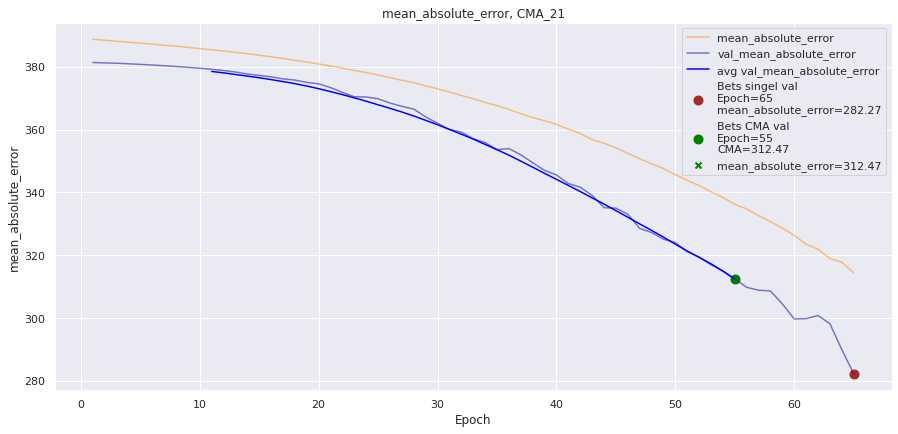

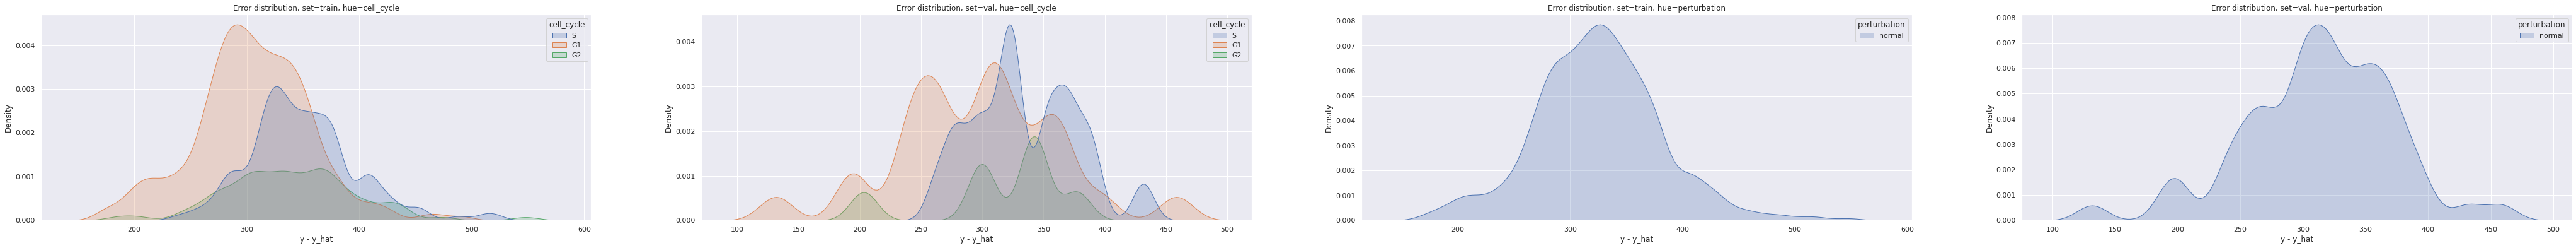

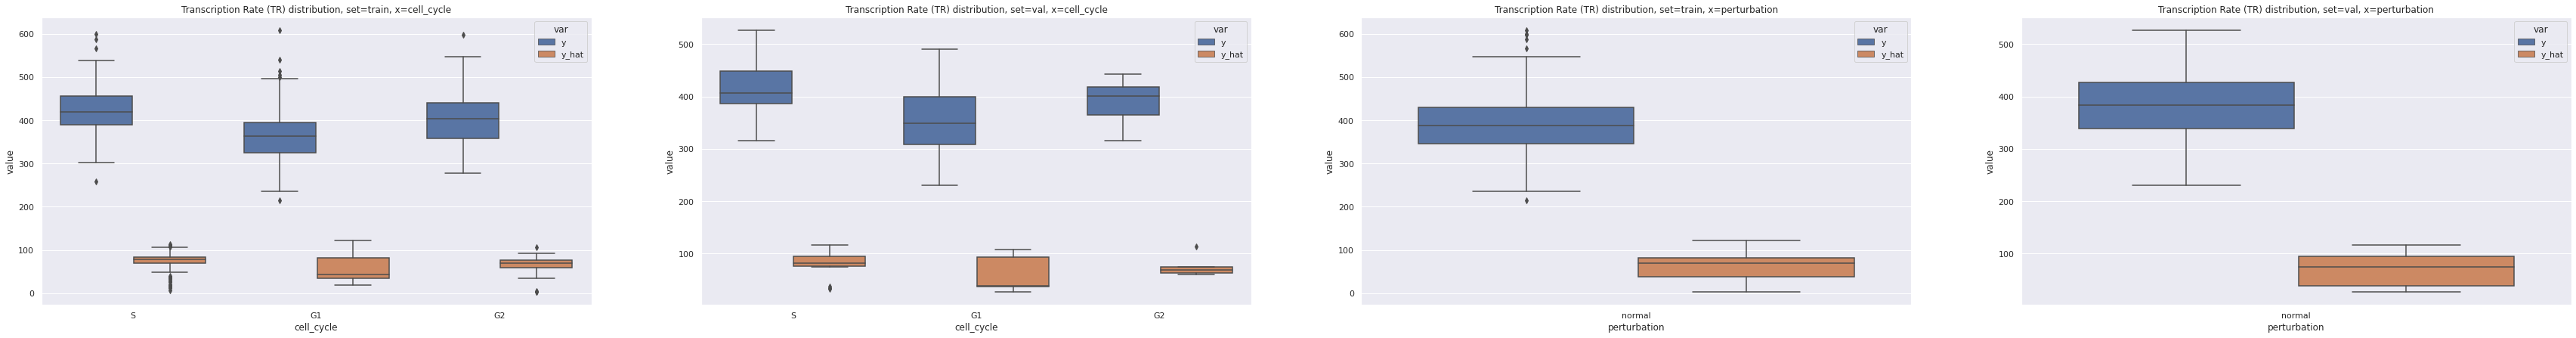

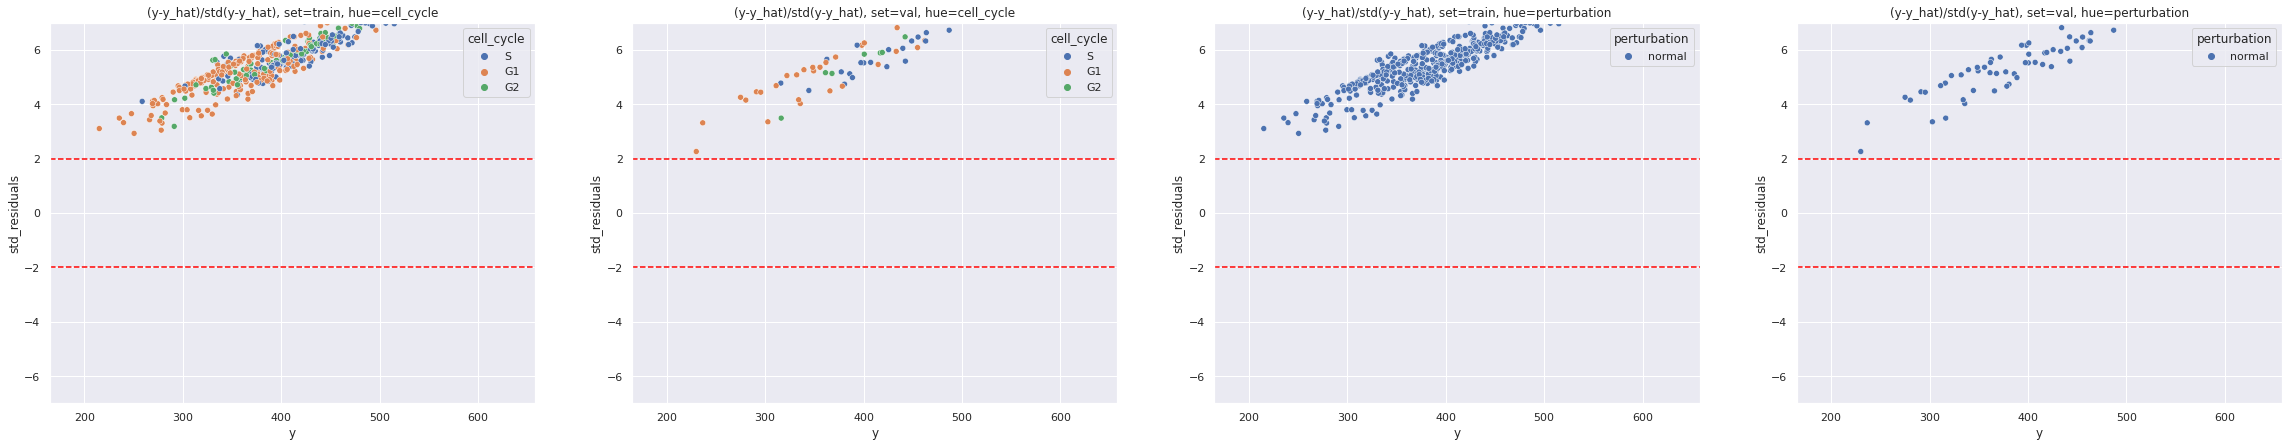

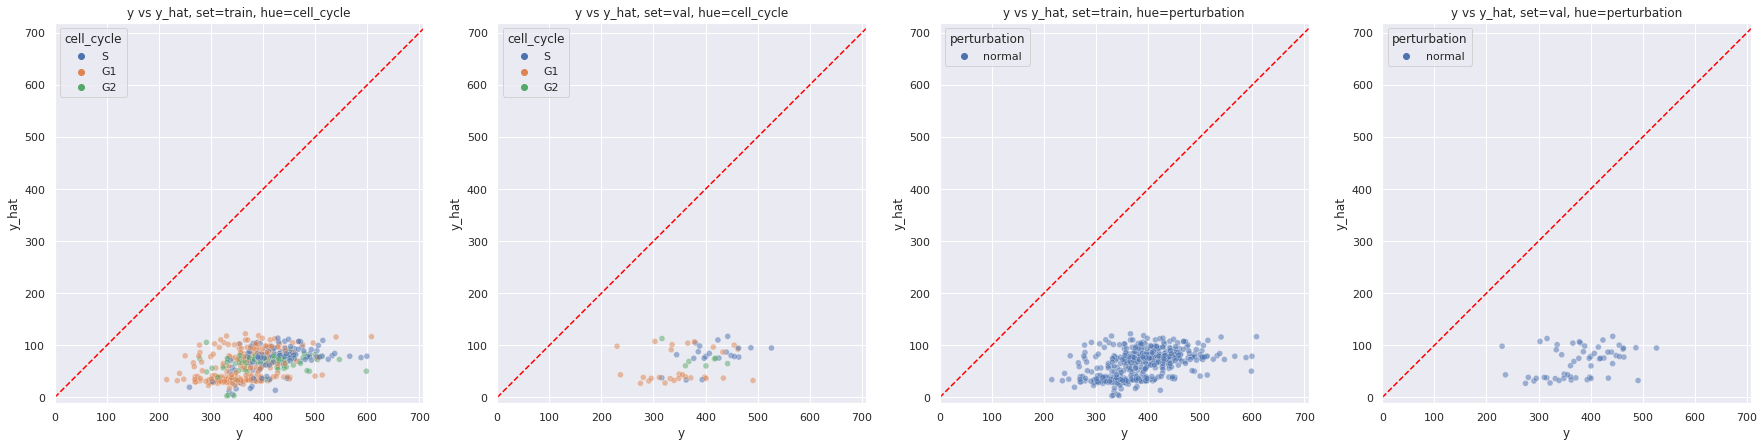

In [37]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         CMA_history=loss_CMA.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [38]:
model_eval.get_metrics(CMA_size=21, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
1,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,324.9315,56.3300,-26.6413,324.9315,108746.4656,324.4315,21,312.3938,13.8577,55,/home/hhughes/Documents/Master_Thesis/Project/...
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,312.4687,60.3517,-24.2541,312.4687,101213.9841,311.9688,21,312.3938,13.8577,55,/home/hhughes/Documents/Master_Thesis/Project/...


## 5.- Best model wrt Central Moving Average of size 31 (CMA_31)

In [39]:
eval_name='CMA_31'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/model/CMA_31/assets


,y,y_hat,mapobject_id_cell,set,y - y_hat,perturbation,cell_cycle
0,489.283569,72.093254,200732,train,417.190315,normal,S
1,349.570404,29.091846,366430,train,320.478558,normal,G1
2,376.229004,67.154930,290989,train,309.074074,normal,G1
3,346.474609,31.580107,359335,train,314.894503,normal,G1
4,381.863281,29.797979,256525,train,352.065302,normal,G1


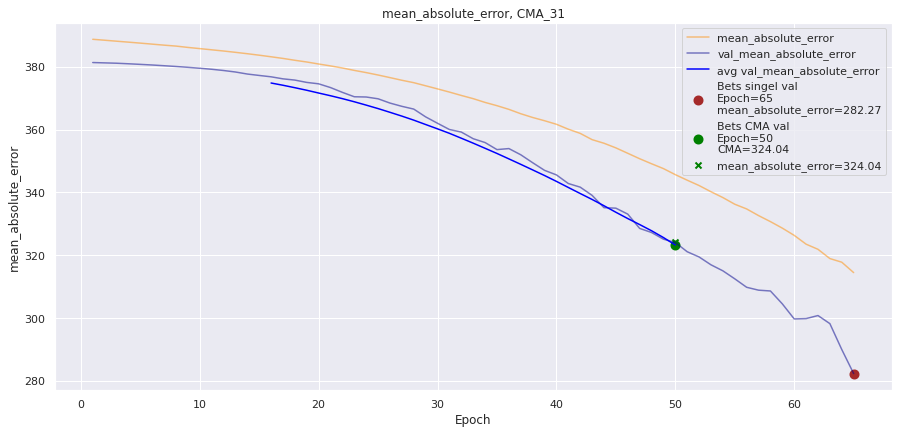

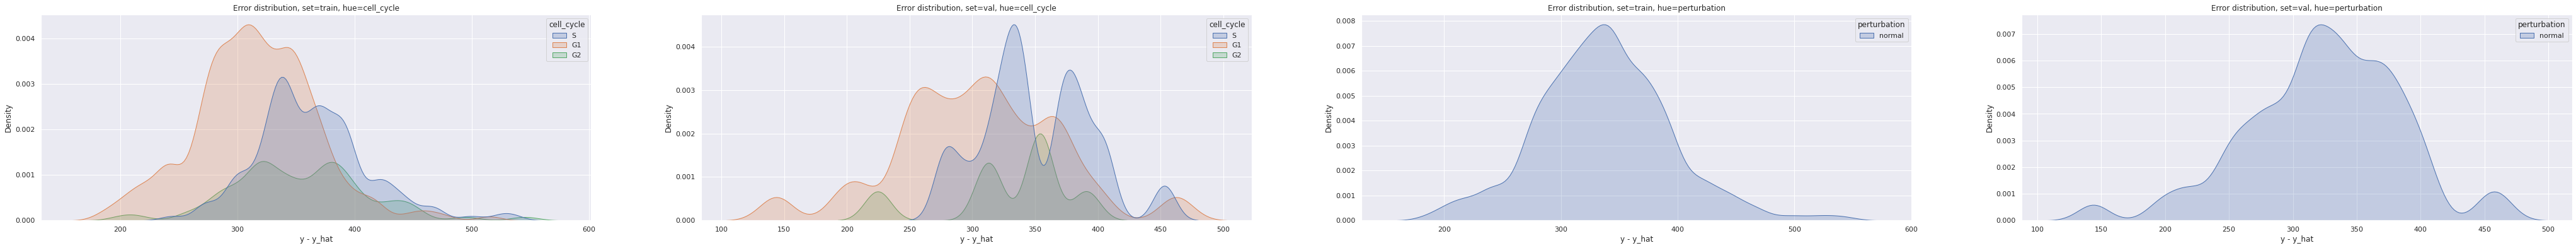

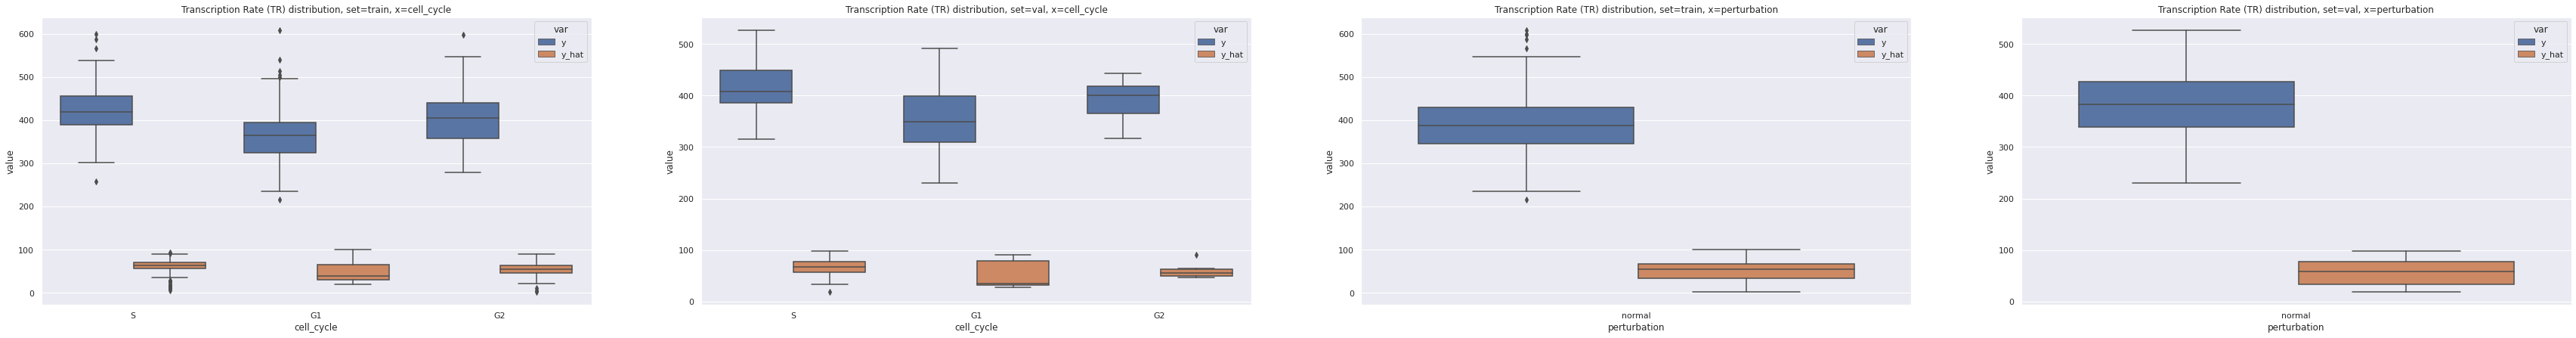

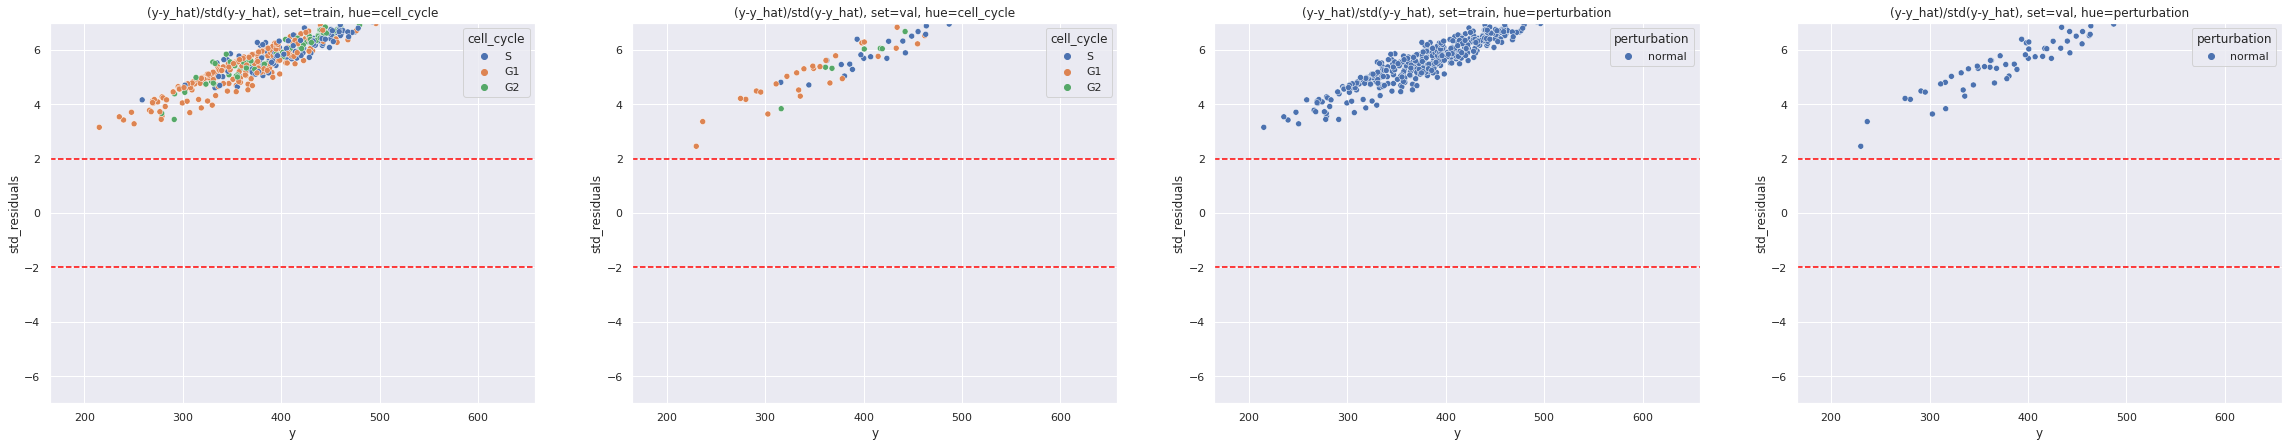

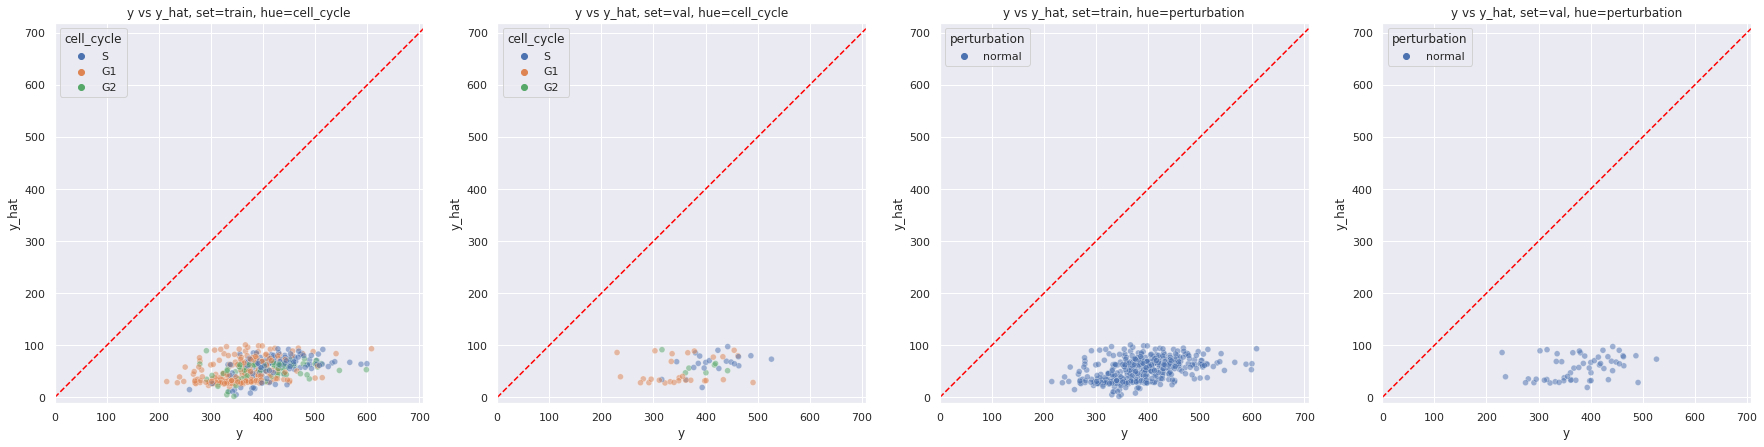

In [40]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         CMA_history=loss_CMA.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [41]:
model_eval.get_metrics(CMA_size=31, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
1,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,336.6114,56.7943,-28.6186,336.6114,116525.6169,336.1114,31,323.2467,19.7293,50,/home/hhughes/Documents/Master_Thesis/Project/...
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,324.0445,60.8014,-26.1059,324.0445,108635.6101,323.5445,31,323.2467,19.7293,50,/home/hhughes/Documents/Master_Thesis/Project/...


# Compare metrics

In [42]:
mask = metrics_df.Set == 'test'
metrics_df[~mask]

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
1,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,295.5020,58.7735,-22.0715,295.5020,90768.0740,295.0020,0,282.2748,0,65,/home/hhughes/Documents/Master_Thesis/Project/...
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,282.2748,62.3479,-19.8335,282.2748,83496.9027,281.7748,0,282.2748,0,65,/home/hhughes/Documents/Master_Thesis/Project/...
4,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,312.1372,57.0099,-24.5890,312.1372,100672.4904,311.6371,11,301.3490,8.6477,60,/home/hhughes/Documents/Master_Thesis/Project/...
5,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,299.6909,61.1037,-22.3248,299.6909,93481.6050,299.1909,11,301.3490,8.6477,60,/home/hhughes/Documents/Master_Thesis/Project/...
7,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,324.9315,56.3300,-26.6413,324.9315,108746.4656,324.4315,21,312.3938,13.8577,55,/home/hhughes/Documents/Master_Thesis/Project/...
8,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,312.4687,60.3517,-24.2541,312.4687,101213.9841,311.9688,21,312.3938,13.8577,55,/home/hhughes/Documents/Master_Thesis/Project/...
10,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,train,336.6114,56.7943,-28.6186,336.6114,116525.6169,336.1114,31,323.2467,19.7293,50,/home/hhughes/Documents/Master_Thesis/Project/...
11,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,324.0445,60.8014,-26.1059,324.0445,108635.6101,323.5445,31,323.2467,19.7293,50,/home/hhughes/Documents/Master_Thesis/Project/...


In [43]:
mask = metrics_df.Set == 'val'
metrics_df[mask].sort_values(by=['MAE', 'Bias', 'Std'])

,Model,Loss,lr,N_Epochs,Conv_L1_reg,Conv_L2_reg,Dense_L1_reg,Dense_L2_reg,Bias_l2_reg,PreTrained,Aug_rand_h_flip,Aug_rand_90deg_r,Aug_Zoom,Aug_Zoom_mode,Aug_rand_int,Aug_RI_mean,Aug_RI_stddev,Set,Bias,Std,R2,MAE,MSE,Huber,CMA_size,CMA,CMA_Std,Epoch,Parameters_file_path
2,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,282.2748,62.3479,-19.8335,282.2748,83496.9027,281.7748,0,282.2748,0,65,/home/hhughes/Documents/Master_Thesis/Project/...
5,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,299.6909,61.1037,-22.3248,299.6909,93481.6050,299.1909,11,301.3490,8.6477,60,/home/hhughes/Documents/Master_Thesis/Project/...
8,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,312.4687,60.3517,-24.2541,312.4687,101213.9841,311.9688,21,312.3938,13.8577,55,/home/hhughes/Documents/Master_Thesis/Project/...
11,Quick_test,huber,0.001,65,0,0,0,0,0,0,1,1,1,random_normal,1,0,0.1667,val,324.0445,60.8014,-26.1059,324.0445,108635.6101,323.5445,31,323.2467,19.7293,50,/home/hhughes/Documents/Master_Thesis/Project/...


In [44]:
# Save metrics
with open(os.path.join(base_path, 'metrics.csv'), 'w') as file:
    metrics_df.to_csv(file, index=False)

# Save a copy into a common dir to comparation among models
temp_path = os.path.join(p['model_path'], 'Model_Metrics_RI_2')
os.makedirs(temp_path, exist_ok=True)
with open(os.path.join(temp_path, p['basename']+'.csv'), 'w') as file:
    metrics_df.to_csv(file, index=False)

In [45]:
msg = 'Notebook execution finished!'
logging.info(msg)